In [39]:
import datetime
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
%matplotlib inline

In [40]:
data=pd.read_csv('NV Take-Home Case_Data Analyst_20180501.csv')

In [41]:
# Set data types and columns

data['sort_hub_inbound_scan'] = pd.to_datetime(data['sort_hub_inbound_scan'])
data['sort_hub_outbound_scan'] = pd.to_datetime(data['sort_hub_outbound_scan'])
data['dest_hub_scan'] = pd.to_datetime(data['dest_hub_scan'])
data['first_attempt_date'] = pd.to_datetime(data['first_attempt_date'])
data['completion_date'] = pd.to_datetime(data['completion_date'])
data['sort_time_hours'] = (data['sort_hub_outbound_scan']-data['sort_hub_inbound_scan']).apply(lambda x: round(x.total_seconds()/3600,2))
data['inbound_hour'] = data['sort_hub_inbound_scan'].apply(lambda x:x.hour)
data['delivery_time_days'] = (data['completion_date'] - data['first_attempt_date']).apply(lambda x: x.total_seconds()/86400,2)
data['sort_inbound_date'] = data['sort_hub_inbound_scan'].apply(lambda x: np.datetime64(x, 'D'))

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27373 entries, 0 to 27372
Data columns (total 16 columns):
order_id                  27373 non-null int64
shipper_id                27373 non-null int64
cod                       27373 non-null int64
from_hub_id               27373 non-null int64
to_hub_id                 27373 non-null int64
sort_hub_inbound_scan     27373 non-null datetime64[ns]
sort_hub_outbound_scan    24837 non-null datetime64[ns]
dest_hub_scan             24568 non-null datetime64[ns]
first_attempt_date        27373 non-null datetime64[ns]
num_attempts              27373 non-null int64
rts                       27373 non-null int64
completion_date           27373 non-null datetime64[ns]
sort_time_hours           24837 non-null float64
inbound_hour              27373 non-null int64
delivery_time_days        27373 non-null float64
sort_inbound_date         27373 non-null datetime64[ns]
dtypes: datetime64[ns](6), float64(2), int64(8)
memory usage: 3.3 MB


In [42]:
#1
# Missing data for outbound scan and desthub scan? Trends-- mostly from certain shipper_id?
# Reasons for missing data? SOPs not followed? system down? problems with the parcels? Trend or one off?

subset = data[(data['sort_hub_outbound_scan'].isnull())]
subset2 = data[(data['dest_hub_scan'].isnull())]
print(len(subset),len(subset2))

2536 2805


In [43]:
# 2
# Mistake in data?? Outbound time before inbound time

data[(data['sort_time_hours']<0)].head(5)

,order_id,shipper_id,cod,from_hub_id,to_hub_id,sort_hub_inbound_scan,sort_hub_outbound_scan,dest_hub_scan,first_attempt_date,num_attempts,rts,completion_date,sort_time_hours,inbound_hour,delivery_time_days,sort_inbound_date
267,268,225294,0,1,5,2018-03-22 16:13:28,2018-03-21 17:37:32,2018-03-24 12:53:21,2018-04-06,2,0,2018-04-07,-22.60,16,1.0,2018-03-22
350,351,221250,0,1,86,2018-03-22 16:15:05,2018-03-21 17:37:33,2018-03-23 09:26:50,2018-04-03,1,0,2018-04-03,-22.63,16,0.0,2018-03-22
351,352,225294,0,1,5,2018-03-26 17:07:34,2018-03-25 13:15:50,2018-03-28 12:29:53,2018-04-08,1,0,2018-04-08,-27.86,17,0.0,2018-03-26
352,353,225294,0,1,54,2018-03-26 16:36:39,2018-03-25 13:15:49,2018-03-28 09:33:44,2018-04-02,1,0,2018-04-02,-27.35,16,0.0,2018-03-26
420,421,225294,0,1,5,2018-03-26 16:59:57,2018-03-25 13:15:50,2018-03-28 17:07:50,2018-03-28,2,0,2018-04-02,-27.74,16,5.0,2018-03-26


In [44]:
# 3
# COD packages take longer to deliver successfully & are more likely to be RTS

pd.value_counts(data[data['cod']==1]['delivery_time_days'])
pd.value_counts(data[data['cod']==0]['delivery_time_days'])


0.0     18596
1.0       390
2.0       194
3.0       126
4.0        40
6.0        18
5.0        16
7.0        14
12.0        9
9.0         4
10.0        3
11.0        2
19.0        2
13.0        2
22.0        1
8.0         1
14.0        1
18.0        1
Name: delivery_time_days, dtype: int64

In [45]:
# 3
# Majority of packages that were returned to seller are COD

pd.value_counts(data[data['rts']==1]['cod'])
pd.value_counts(data['cod'])


0    19420
1     7953
Name: cod, dtype: int64

In [46]:
# 3
# COD vs non-COD-- proportion returned to seller

cod = pd.value_counts(data[data['cod']==1]['rts'])
noncod = pd.value_counts(data[data['cod']==0]['rts'])

# Proportion of COD packages returned to seller

cod[1]/(cod[1]+cod[0])

0.1730164717716585

In [47]:
# Proportion of non-COD packages returned to seller

noncod[1]/(noncod[0]+noncod[1])

0.005509783728115345

Text(0,0.5,'No. of successfully delivered packages')

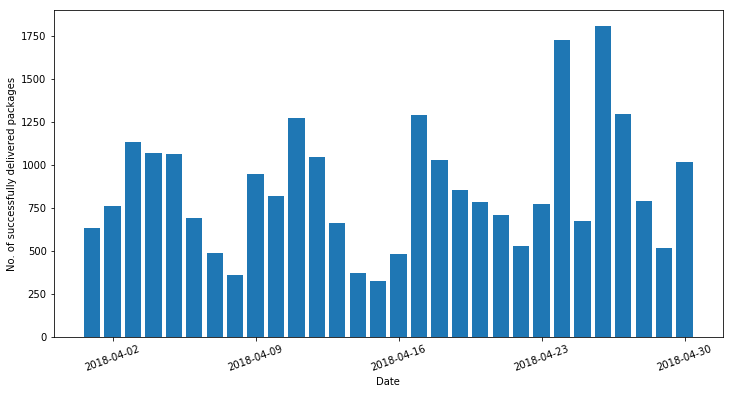

In [48]:
# 4
# Successfully delivered packages per day

compdate,numcompleted=[],[]
for i in pd.unique(data['completion_date']):
    compdate.append(i)
    numcompleted.append(len(data[(data['completion_date']==i)&(data['rts']==0)]))
plt.figure(figsize=(12,6))
plt.bar(compdate,numcompleted)
plt.xticks(rotation=20)
plt.xlabel('Date')
plt.ylabel('No. of successfully delivered packages')

(array([736753., 736760., 736767., 736774., 736781., 736788., 736795.,
        736802., 736809., 736816.]), <a list of 10 Text xticklabel objects>)

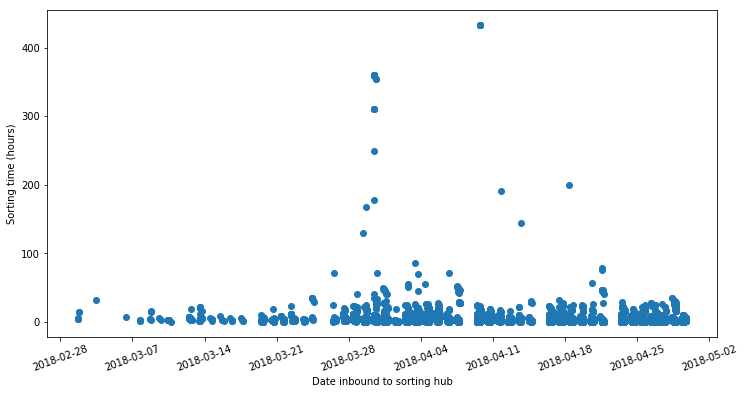

In [49]:
# 5

# Sort time across the 2 month period
# Note: bunch of outliers in end march

plt.figure(figsize=(12,6))
data1=data[data['sort_time_hours']>0]
plt.plot_date(data1['sort_hub_inbound_scan'],data1['sort_time_hours'])
plt.xlabel('Date inbound to sorting hub')
plt.ylabel('Sorting time (hours)')
plt.xticks(rotation=20)

([<matplotlib.patches.Wedge at 0x1174828d0>,
 [Text(-1.01627,0.420952,'210597'),
  Text(0.914617,-0.611127,'200250'),
  Text(1.07886,-0.214599,'87815')],
 [Text(-0.554328,0.22961,'87.5%  (14)'),
  Text(0.498882,-0.333342,'6.2%  (1)'),
  Text(0.588471,-0.117054,'6.2%  (1)')])

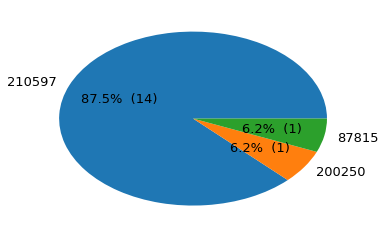

In [50]:
# 5
# Delayed sorting by shipper_id

def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.1f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct

values=pd.value_counts(data[(data['sort_time_hours']>100)][:-7]['shipper_id'])
plt.rc('font', size=13)  
plt.pie(values,autopct=make_autopct(values),labels=[210597,200250,87815])

In [51]:
# 5
# breakdown of packages inbound on 28/29 Mar by shipper_id

pd.value_counts(data[(data['sort_inbound_date']==datetime.datetime(2018,3,29)) | (data['sort_inbound_date']==datetime.datetime(2018,3,30))]['shipper_id'])[:5]

43355     394
87815     384
8055      101
210597     59
115842     42
Name: shipper_id, dtype: int64

([<matplotlib.patches.Wedge at 0x11778e588>,
 [Text(-0.914617,0.611127,'1000 - 1059'),
  Text(0.777817,-0.777817,'1500 - 1559'),
  Text(1.07886,-0.214599,'1700 - 1759')],
 [Text(-0.498882,0.333342,'81.2%  (13)'),
  Text(0.424264,-0.424264,'12.5%  (2)'),
  Text(0.588471,-0.117054,'6.2%  (1)')])

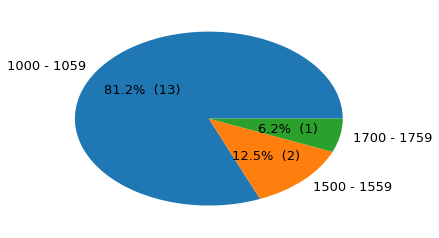

In [52]:
# 5
# Delayed sorting by inbound time of day

plt.rc('font', size=13)  
delayed_sort=pd.value_counts(data[(data['sort_time_hours']>100)][:-7]['inbound_hour'])
plt.pie(delayed_sort,autopct=make_autopct(delayed_sort),labels=['1000 - 1059','1500 - 1559','1700 - 1759'])


Text(0,0.5,'Avg daily no. of packages')

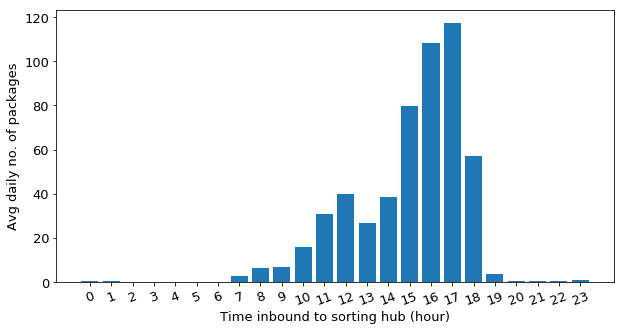

In [53]:
# 6

# Avg no. of packages inbound to sorting hub at each hour

num_days = len(pd.unique(data['sort_inbound_date']))
unique_inboundhour,num_inboundhour=[],[]
for i in pd.unique(data['inbound_hour']):
    unique_inboundhour.append(i)
    num_inboundhour.append(len(data[(data['inbound_hour']==i)])/num_days)
    
plt.figure(figsize=(10,5))
plt.xticks(np.arange(0, 24, 1))
plt.bar(unique_inboundhour,num_inboundhour)
plt.xticks(rotation=20)
plt.xlabel('Time inbound to sorting hub (hour)')
plt.ylabel('Avg daily no. of packages')

Text(0,0.5,'Average sorting time')

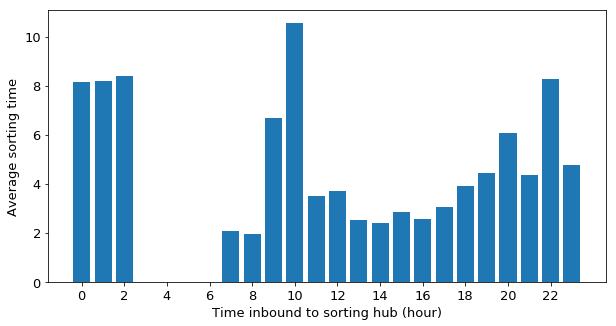

In [54]:
# 6
# Effect on sort time

hours,sorthours=[],[]
for i in pd.unique(data['inbound_hour']):
    hours.append(i)
    sorthours.append(np.mean(data[data['inbound_hour']==i]['sort_time_hours']))

plt.figure(figsize=(10,5))
plt.bar(hours,sorthours)
plt.xticks(np.arange(0, 24, 2))
plt.xlabel('Time inbound to sorting hub (hour)')
plt.ylabel('Average sorting time')

In [55]:
# 6
# Get 1st and 3rd quartiles for sort_time

print(data['sort_time_hours'].quantile(q=0.25))
print(data['sort_time_hours'].quantile(q=0.75))


0.94
3.9
